<div><span style="background-color: #9e4244; padding-top: 80px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: white; font-size: 22px; font-weight: bold">Session 1: Introduction to Credit Card Fraud Analysis</span></div>

by BYJ Cirio

<div class="alert alert-danger alert-info">
     In this notebook we will be having an overview of the credit card fraud dataset and some outlier detection techniques. Specifically, the topics covered are as follows:<br>
    <ol>
        <li>Data Cleaning and Pre-processing</li>
        <li>Exploratory Data Analysis</li>
        <li>Outlier Detection Techniques: Z-score and Isolation Forest</li>
        <li>Baselining</li>
        <li><i>Exercise: Find and perform EDA and outlier detection on SDG-related imbalanced dataset</i></li>
    </ol>
</div>

In [1]:
# general libraries
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

# Outlier detection
import scipy.stats as stats
from sklearn.ensemble import IsolationForest

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Data Cleaning and Preprocessing </span></div>

In [6]:
cc_fraud = pd.read_csv('cc_fraud_data_sprint2.csv')
cc_fraud['full_name'] = cc_fraud['first'] + ' ' + cc_fraud['last']
print(cc_fraud.shape)
cc_fraud.head()

(3641, 26)


,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,full_name
0,0721-7502166-2,2.280000e+15,Ina,Warren,F,"953 Baker Street, Azalea Grove",Dipolog,PH,130759,8.5667,...,07/05/2021,5:05:28,1.620364e+09,shopping_net,91.70,0.0,Carousell,8.033511,123.834444,Ina Warren
1,0721-7502166-2,2.280000e+15,Ina,Warren,F,"953 Baker Street, Azalea Grove",Dipolog,PH,130759,8.5667,...,03/07/2021,12:13:55,1.625314e+09,kids_pets,246.42,0.0,Bioresearch,9.446718,124.154834,Ina Warren
2,0721-7502166-2,2.280000e+15,Ina,Warren,F,"953 Baker Street, Azalea Grove",Dipolog,PH,130759,8.5667,...,15/09/2021,6:32:24,1.631688e+09,gas_transport,85.73,0.0,SeaOil Philippines Inc.,9.069974,123.933139,Ina Warren
3,0721-7502166-2,2.280000e+15,Ina,Warren,F,"953 Baker Street, Azalea Grove",Dipolog,PH,130759,8.5667,...,10/06/2020,11:37:53,1.591789e+09,entertainment,7.75,0.0,Starmedia Entertainment,7.849510,123.961913,Ina Warren
4,0721-7502166-2,2.280000e+15,Ina,Warren,F,"953 Baker Street, Azalea Grove",Dipolog,PH,130759,8.5667,...,30/11/2020,9:42:53,1.606729e+09,gas_transport,58.55,0.0,Caltex (Chevron Corporation),9.103602,124.060359,Ina Warren


In [8]:
cc_fraud['full_name'].value_counts()

Christopher Kim      736
Mark Diaz            712
James Barnes         711
Robert Valenzuela    709
Natalia Anderson     705
Ina Warren            31
Justin Beard          11
Leslie Greene         10
Samuel Jenkins         9
Dale Carter            7
Name: full_name, dtype: int64

### 1. Drop Unnecessary Variables

In [13]:
to_drop = ['ssn', 'cc_num', 'first', 'last', 'street', 'state', 'zip', 'acct_num', 'trans_num', 'unix_time', 'full_name']
cc_clean = cc_fraud.drop(to_drop, axis=1)
cc_clean.head()

,gender,city,lat,long,city_pop,job,dob,trans_date,trans_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,F,Dipolog,8.5667,123.3333,130759,Archivist,10/02/1963,07/05/2021,5:05:28,shopping_net,91.70,0.0,Carousell,8.033511,123.834444
1,F,Dipolog,8.5667,123.3333,130759,Archivist,10/02/1963,03/07/2021,12:13:55,kids_pets,246.42,0.0,Bioresearch,9.446718,124.154834
2,F,Dipolog,8.5667,123.3333,130759,Archivist,10/02/1963,15/09/2021,6:32:24,gas_transport,85.73,0.0,SeaOil Philippines Inc.,9.069974,123.933139
3,F,Dipolog,8.5667,123.3333,130759,Archivist,10/02/1963,10/06/2020,11:37:53,entertainment,7.75,0.0,Starmedia Entertainment,7.849510,123.961913
4,F,Dipolog,8.5667,123.3333,130759,Archivist,10/02/1963,30/11/2020,9:42:53,gas_transport,58.55,0.0,Caltex (Chevron Corporation),9.103602,124.060359


### 2. Clean Date and Time

In [14]:
# pre-processing time
# transaction date
cc_clean['trans_datetime'] = pd.to_datetime(cc_clean['trans_date'])
cc_clean['trans_date'] = cc_clean['trans_datetime'].dt.date
cc_clean['trans_year'] = cc_clean['trans_datetime'].dt.year.astype(str)
cc_clean['trans_month'] = cc_clean['trans_datetime'].dt.month
cc_clean['trans_day'] = cc_clean['trans_datetime'].dt.day

# transaction time
cc_clean['trans_hour'] = cc_clean['trans_time'].str[:2].apply(lambda x: x[0] if x[1]==':' else x).astype(int)

# convert month to string
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
cc_clean['trans_month_'] = cc_clean['trans_month'].map(month_map)

# convert time to part of day
def get_part_of_day(hour):
    """Return the part of day given the hour of day"""
    if (hour > 22) or (hour <= 6):
        return 'early morning'
    elif hour <= 11:
        return 'breakfast'
    elif hour <= 14:
        return 'lunch'
    elif hour <= 17:
        return 'afternoon'
    else:
        return 'dinner'

cc_clean.loc[:, 'part_of_day'] = cc_clean['trans_hour'].apply(get_part_of_day)
cc_clean.head()

TypeError: ignored

### 3. Age

In [15]:
cc_clean['dob_datetime'] = pd.to_datetime(cc_clean['dob'])
cc_clean['dob'] = cc_clean['dob_datetime'].dt.date
cc_clean['age'] = (cc_clean['trans_date'] - cc_clean['dob'])/365
cc_clean['age'] = cc_clean['age'].apply(lambda x: x.days)
cc_clean.head()

,gender,city,lat,long,city_pop,job,dob,trans_date,trans_time,category,...,is_fraud,merchant,merch_lat,merch_long,trans_datetime,trans_year,trans_month,trans_day,dob_datetime,age
0,F,Dipolog,8.5667,123.3333,130759,Archivist,1963-10-02,2021-07-05,5:05:28,shopping_net,...,0.0,Carousell,8.033511,123.834444,2021-07-05,2021.0,7.0,5.0,1963-10-02,57.0
1,F,Dipolog,8.5667,123.3333,130759,Archivist,1963-10-02,2021-03-07,12:13:55,kids_pets,...,0.0,Bioresearch,9.446718,124.154834,2021-03-07,2021.0,3.0,7.0,1963-10-02,57.0
2,F,Dipolog,8.5667,123.3333,130759,Archivist,1963-10-02,2021-09-15,6:32:24,gas_transport,...,0.0,SeaOil Philippines Inc.,9.069974,123.933139,2021-09-15,2021.0,9.0,15.0,1963-10-02,57.0
3,F,Dipolog,8.5667,123.3333,130759,Archivist,1963-10-02,2020-10-06,11:37:53,entertainment,...,0.0,Starmedia Entertainment,7.849510,123.961913,2020-10-06,2020.0,10.0,6.0,1963-10-02,57.0
4,F,Dipolog,8.5667,123.3333,130759,Archivist,1963-10-02,2020-11-30,9:42:53,gas_transport,...,0.0,Caltex (Chevron Corporation),9.103602,124.060359,2020-11-30,2020.0,11.0,30.0,1963-10-02,57.0


### 4. Retain final columns

In [16]:
to_drop2 = ['dob', 'trans_date', 'trans_time', 'trans_datetime', 'trans_month', 'trans_hour', 'dob_datetime']
cc_final = cc_clean.drop(to_drop2, axis=1)
cc_final.head()

KeyError: ignored

In [17]:
cc_final.info()

NameError: ignored

In [ ]:
cc_final.to_csv('cc_fraud_clean.csv', index=None)

### 5. Perform Outlier Detection

#### a. Z-score

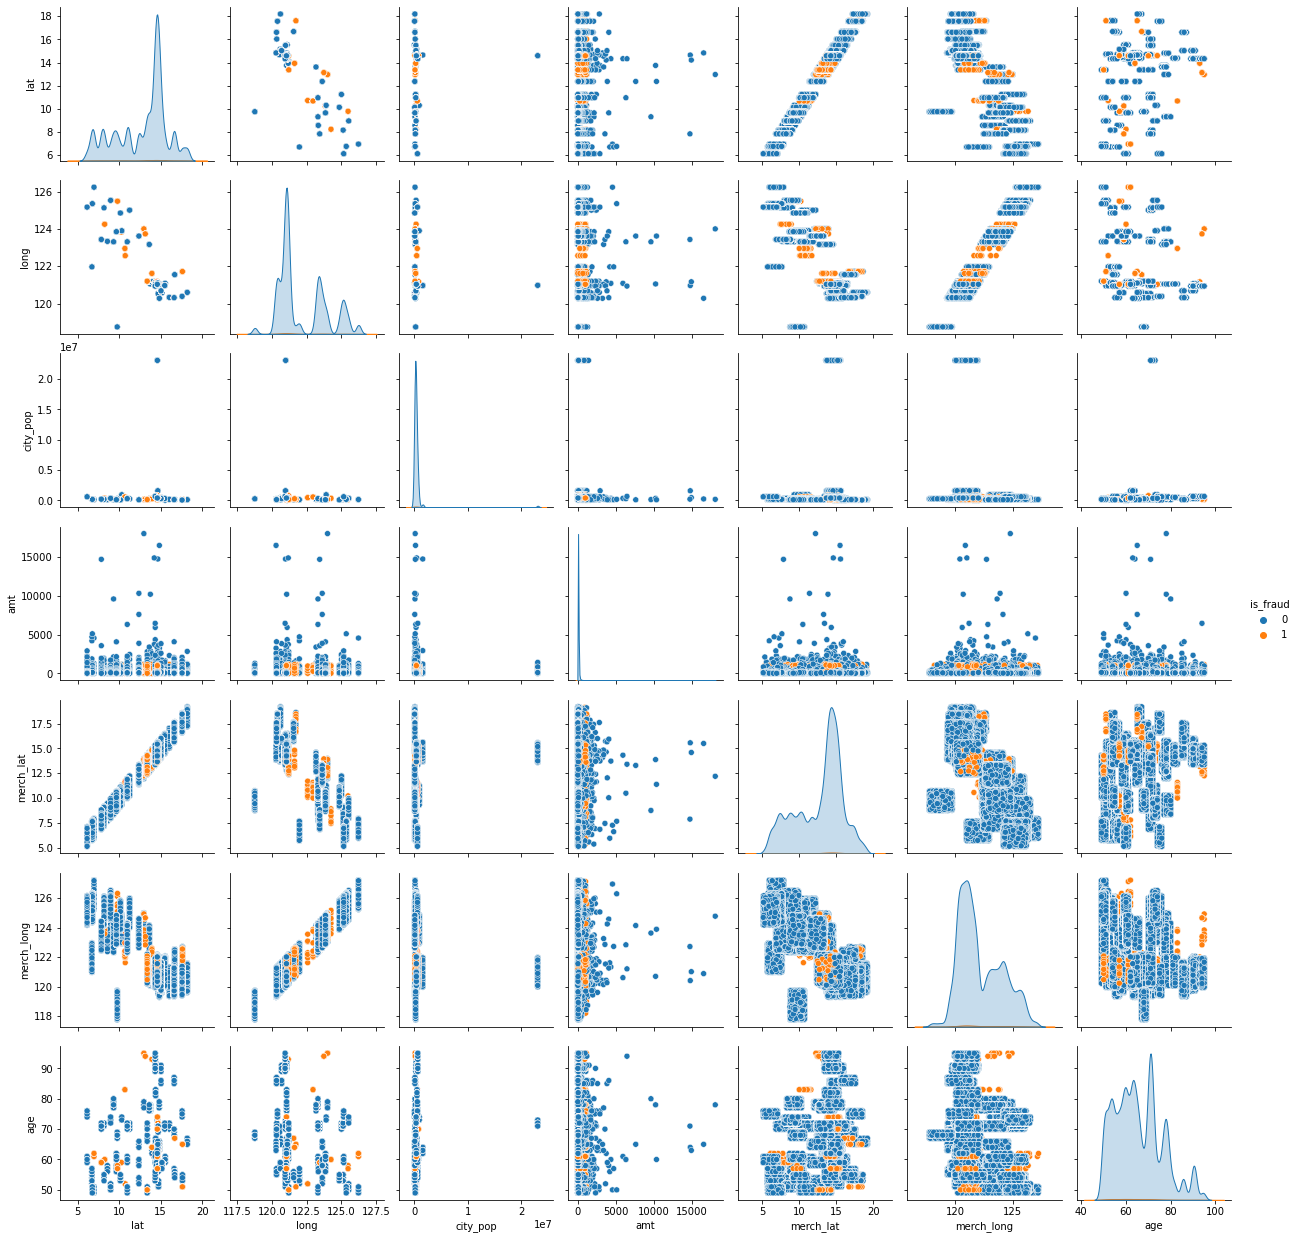

In [ ]:
numerical_cols = ['lat', 'long', 'city_pop', 'amt', 'merch_lat', 'merch_long', 'age', 'is_fraud']
cc_fraud_quant = cc_final[numerical_cols]
sns.pairplot(cc_fraud_quant, hue='is_fraud')
plt.show()

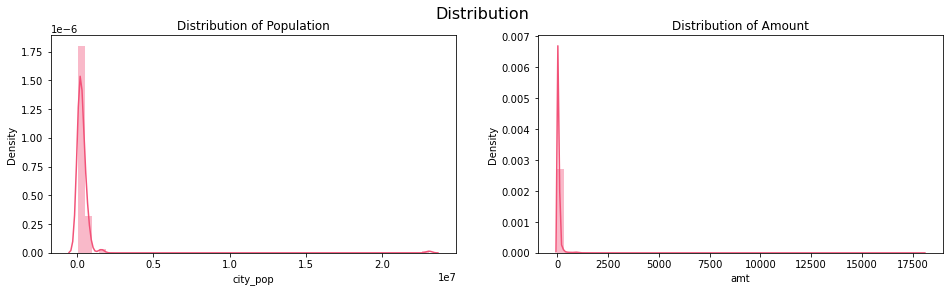

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))
fig.suptitle('Distribution', fontsize=16)

# population
sns.distplot(cc_fraud_quant["city_pop"], ax=ax[0], color="#F25278")
ax[0].set_title('Distribution of Population')

# amount
sns.distplot(cc_fraud_quant["amt"], ax=ax[1], color="#F25278")
ax[1].set_title('Distribution of Amount')
plt.show()

In [ ]:
# getting outliers for population
cc_fraud_quant['city_pop_zscore'] = stats.zscore(cc_fraud_quant['city_pop'])
cc_fraud_quant['city_pop_zscore'] = cc_fraud_quant['city_pop_zscore'].apply(lambda x: abs(x))
cc_fraud_quant[cc_fraud_quant['city_pop_zscore'] > 3]

,lat,long,city_pop,amt,merch_lat,merch_long,age,is_fraud,city_pop_zscore
31,14.5958,120.9772,23088000,966.24,14.133430,121.223118,71,1,11.719227
32,14.5958,120.9772,23088000,275.37,15.290354,120.246084,71,1,11.719227
33,14.5958,120.9772,23088000,326.96,15.402101,121.332516,71,1,11.719227
34,14.5958,120.9772,23088000,1047.59,15.166276,121.955649,71,1,11.719227
35,14.5958,120.9772,23088000,726.54,14.689498,120.762294,71,1,11.719227
...,...,...,...,...,...,...,...,...,...
738,14.5958,120.9772,23088000,81.24,15.450962,120.090041,71,0,11.719227
739,14.5958,120.9772,23088000,87.64,15.055760,121.802279,71,0,11.719227
740,14.5958,120.9772,23088000,91.55,15.420791,121.330996,72,0,11.719227
741,14.5958,120.9772,23088000,52.86,15.197789,120.896767,71,0,11.719227


In [ ]:
# getting outliers for amount
cc_fraud_quant['amt_zscore'] = stats.zscore(cc_fraud_quant['amt'])
cc_fraud_quant['amt_zscore'] = cc_fraud_quant['amt_zscore'].apply(lambda x: abs(x))
cc_fraud_quant[cc_fraud_quant['amt_zscore'] > 3]

,lat,long,city_pop,amt,merch_lat,merch_long,age,is_fraud,city_pop_zscore,amt_zscore
31,14.5958,120.9772,23088000,966.24,14.133430,121.223118,71,1,11.719227,4.869521
34,14.5958,120.9772,23088000,1047.59,15.166276,121.955649,71,1,11.719227,5.311663
35,14.5958,120.9772,23088000,726.54,14.689498,120.762294,71,1,11.719227,3.566740
37,14.5958,120.9772,23088000,1004.66,14.824212,120.504185,71,1,11.719227,5.078336
514,14.5958,120.9772,23088000,708.59,14.763381,120.228513,72,0,11.719227,3.469181
...,...,...,...,...,...,...,...,...,...,...
99977,14.5833,121.0333,386276,840.01,13.874266,121.073065,61,1,0.035187,4.183455
99978,14.5833,121.0333,386276,1008.36,14.781970,120.316860,61,1,0.035187,5.098446
99979,14.5833,121.0333,386276,1079.33,13.611516,121.662940,61,1,0.035187,5.484171
99980,14.5833,121.0333,386276,948.34,14.429325,121.641503,61,1,0.035187,4.772234


#### B. Isolation Forest

In [ ]:
cc_fraud_quant_sub = cc_fraud_quant[['city_pop', 'amt']]

# initialize baseline
iso=IsolationForest(random_state=143)
iso.fit(cc_fraud_quant_sub)

# prediction of outliers is based on contamination level
y_pred_IF = iso.fit_predict(cc_fraud_quant_sub)
IF_scores = iso.score_samples(cc_fraud_quant_sub)

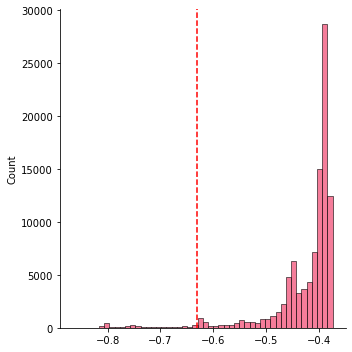

In [ ]:
sns.displot(IF_scores, bins=50, color="#F25278")
plt.axvline(-0.63, linestyle='--', color='r')
plt.show()

In [ ]:
y_pred_IF = (IF_scores > -0.63) * 2 - 1
cc_fraud_quant['IF_score'] = y_pred_IF
cc_fraud_quant[cc_fraud_quant['IF_score'] == -1]

,lat,long,city_pop,amt,merch_lat,merch_long,age,is_fraud,city_pop_zscore,amt_zscore,IF_score
31,14.5958,120.9772,23088000,966.24,14.133430,121.223118,71,1,11.719227,4.869521,-1
32,14.5958,120.9772,23088000,275.37,15.290354,120.246084,71,1,11.719227,1.114609,-1
33,14.5958,120.9772,23088000,326.96,15.402101,121.332516,71,1,11.719227,1.395003,-1
34,14.5958,120.9772,23088000,1047.59,15.166276,121.955649,71,1,11.719227,5.311663,-1
35,14.5958,120.9772,23088000,726.54,14.689498,120.762294,71,1,11.719227,3.566740,-1
...,...,...,...,...,...,...,...,...,...,...,...
99977,14.5833,121.0333,386276,840.01,13.874266,121.073065,61,1,0.035187,4.183455,-1
99978,14.5833,121.0333,386276,1008.36,14.781970,120.316860,61,1,0.035187,5.098446,-1
99979,14.5833,121.0333,386276,1079.33,13.611516,121.662940,61,1,0.035187,5.484171,-1
99980,14.5833,121.0333,386276,948.34,14.429325,121.641503,61,1,0.035187,4.772234,-1


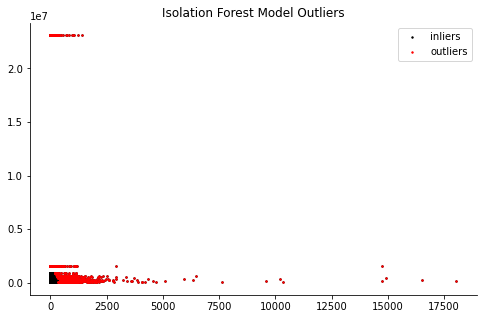

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

iso_out = cc_fraud_quant[cc_fraud_quant['IF_score'] == -1].index

# Plot data set
ax.scatter(cc_fraud_quant['amt'],
           cc_fraud_quant['city_pop'],
           color='black', label='inliers', s=2.)
ax.scatter(cc_fraud_quant['amt'][iso_out],
           cc_fraud_quant['city_pop'][iso_out],
           color='red', label='outliers', s=2.)
ax.set_title("Isolation Forest Model Outliers")
ax.legend()

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    ax.spines[spine].set_visible(False)

plt.show()

In [ ]:
iso_in = cc_fraud_quant[cc_fraud_quant['IF_score'] == 1].index
cc_final = cc_final.loc[iso_in].reset_index(drop=True)
cc_final

,gender,city,lat,long,city_pop,job,category,amt,is_fraud,merchant,merch_lat,merch_long,trans_year,trans_day,trans_month_,part_of_day,age
0,M,Dipolog,8.5667,123.3333,130759,Archivist,shopping_net,91.70,0,Carousell,8.033511,123.834444,2021,5,Jul,early morning,57
1,M,Dipolog,8.5667,123.3333,130759,Archivist,kids_pets,246.42,0,Bioresearch,9.446718,124.154834,2021,7,Mar,lunch,57
2,M,Dipolog,8.5667,123.3333,130759,Archivist,gas_transport,85.73,0,SeaOil Philippines Inc.,9.069974,123.933139,2021,15,Sep,early morning,57
3,M,Dipolog,8.5667,123.3333,130759,Archivist,entertainment,7.75,0,Starmedia Entertainment,7.849510,123.961913,2020,6,Oct,breakfast,57
4,M,Dipolog,8.5667,123.3333,130759,Archivist,gas_transport,58.55,0,Caltex (Chevron Corporation),9.103602,124.060359,2020,30,Nov,breakfast,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97440,M,Mandaluyong City,14.5833,121.0333,386276,Air traffic controller,misc_pos,8.23,0,Bratpack,14.159277,120.498417,2020,23,Dec,early morning,62
97441,M,Mandaluyong City,14.5833,121.0333,386276,Air traffic controller,food_dining,26.45,0,The Moment Group,14.341867,120.359051,2020,28,Mar,lunch,62
97442,M,Mandaluyong City,14.5833,121.0333,386276,Air traffic controller,grocery_pos,114.00,0,Ever Supermarket,15.457733,122.015514,2021,25,Jan,breakfast,62
97443,M,Mandaluyong City,14.5833,121.0333,386276,Air traffic controller,home,123.46,0,Japan Homes,14.248353,120.760079,2020,4,Aug,dinner,62


### 6. One-hot encode categorical variables

In [ ]:
to_drop3 = []
for col in tqdm(cc_final.columns):
    if cc_final[col].dtype == 'O':
        dummies = pd.get_dummies(cc_final[col], prefix=col, drop_first=False)
        cc_final = pd.concat([cc_final, dummies], axis=1)
        to_drop3.append(col)
cc_final = cc_final.drop(to_drop3, axis=1)
cc_final.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 42.61it/s]


,lat,long,city_pop,amt,is_fraud,merch_lat,merch_long,trans_day,age,gender_M,...,trans_month__Mar,trans_month__May,trans_month__Nov,trans_month__Oct,trans_month__Sep,part_of_day_afternoon,part_of_day_breakfast,part_of_day_dinner,part_of_day_early morning,part_of_day_lunch
0,8.5667,123.3333,130759,91.70,0,8.033511,123.834444,5,57,1,...,0,0,0,0,0,0,0,0,1,0
1,8.5667,123.3333,130759,246.42,0,9.446718,124.154834,7,57,1,...,1,0,0,0,0,0,0,0,0,1
2,8.5667,123.3333,130759,85.73,0,9.069974,123.933139,15,57,1,...,0,0,0,0,1,0,0,0,1,0
3,8.5667,123.3333,130759,7.75,0,7.849510,123.961913,6,57,1,...,0,0,0,1,0,0,1,0,0,0
4,8.5667,123.3333,130759,58.55,0,9.103602,124.060359,30,57,1,...,0,0,1,0,0,0,1,0,0,0


In [ ]:
cc_final.to_csv('cc_df.csv', index=None)

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Exploratory Data Analysis </span></div>

### Valid vs Fraud

In [ ]:
cc_clean = cc_clean.loc[iso_in].reset_index(drop=True)

valid    97069
fraud      376
Name: Class, dtype: int64

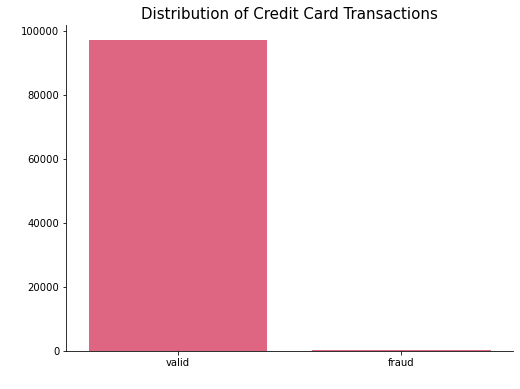

In [ ]:
fraud_map = {0: 'valid', 1: 'fraud'}
cc_fraud_eda = cc_clean.copy()
cc_fraud_eda['Class'] = cc_fraud_eda['is_fraud'].map(fraud_map)

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x=cc_fraud_eda['Class'],
              order=cc_fraud_eda['Class'].value_counts().index,
              color="#F25278")
ax.set_xlabel(' ')
ax.set_ylabel(' ')
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
ax.set_title(f'Distribution of Credit Card Transactions', size=15, y=1)
display(cc_fraud_eda['Class'].value_counts())
plt.show()

### Gender

Male    97445
Name: Gender_, dtype: int64

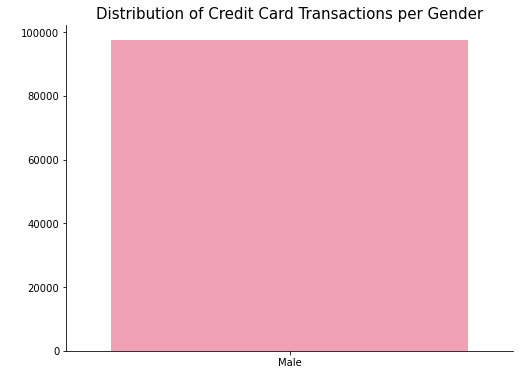

In [ ]:
gender_map = {'M': 'Male', 'F': 'Female'}
cc_fraud_eda['Gender_'] = cc_fraud_eda['gender'].map(gender_map)

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x=cc_fraud_eda['Gender_'],
              order=cc_fraud_eda['Gender_'].value_counts().index,
              color="#FC94AF")
ax.set_xlabel(' ')
ax.set_ylabel(' ')
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
ax.set_title(f'Distribution of Credit Card Transactions per Gender', size=15, y=1)
display(cc_fraud_eda['Gender_'].value_counts())
plt.show()

### Location

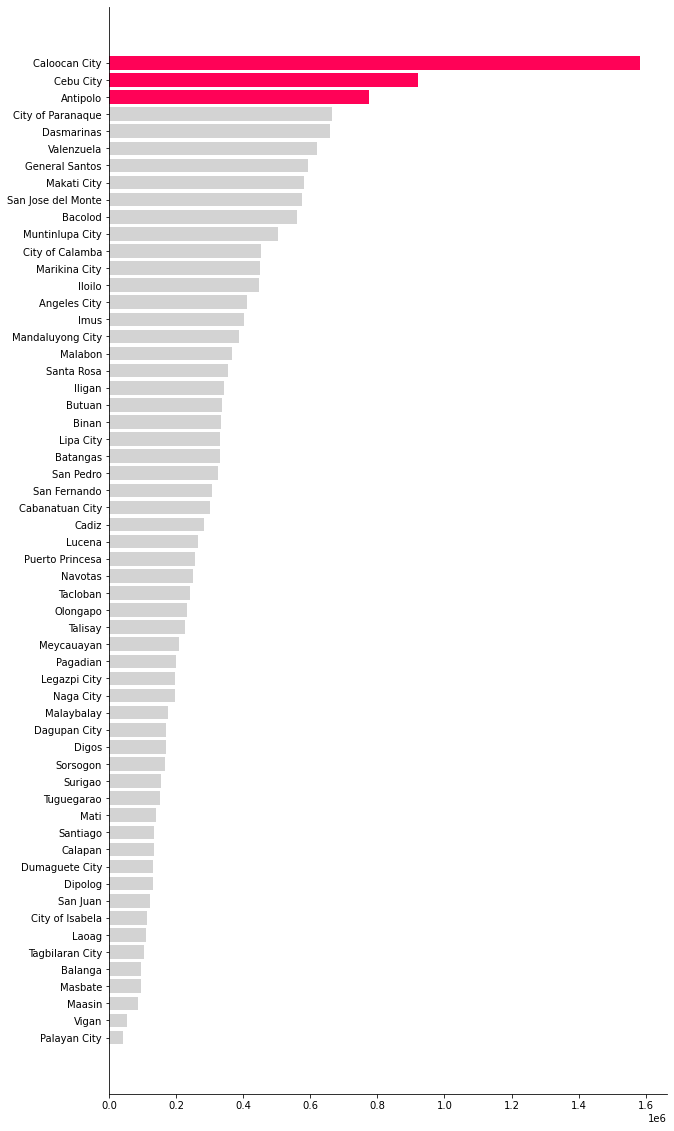

In [ ]:
cc_city = cc_fraud_eda.drop_duplicates(subset=['city']).reset_index(drop=True).sort_values(['city_pop'])

colors_l = ['lightgray'] * len(cc_city.city.value_counts())
colors_l[-3:] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 20))
ax.barh(cc_city.city, cc_city.city_pop, color=colors_l)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
plt.show()

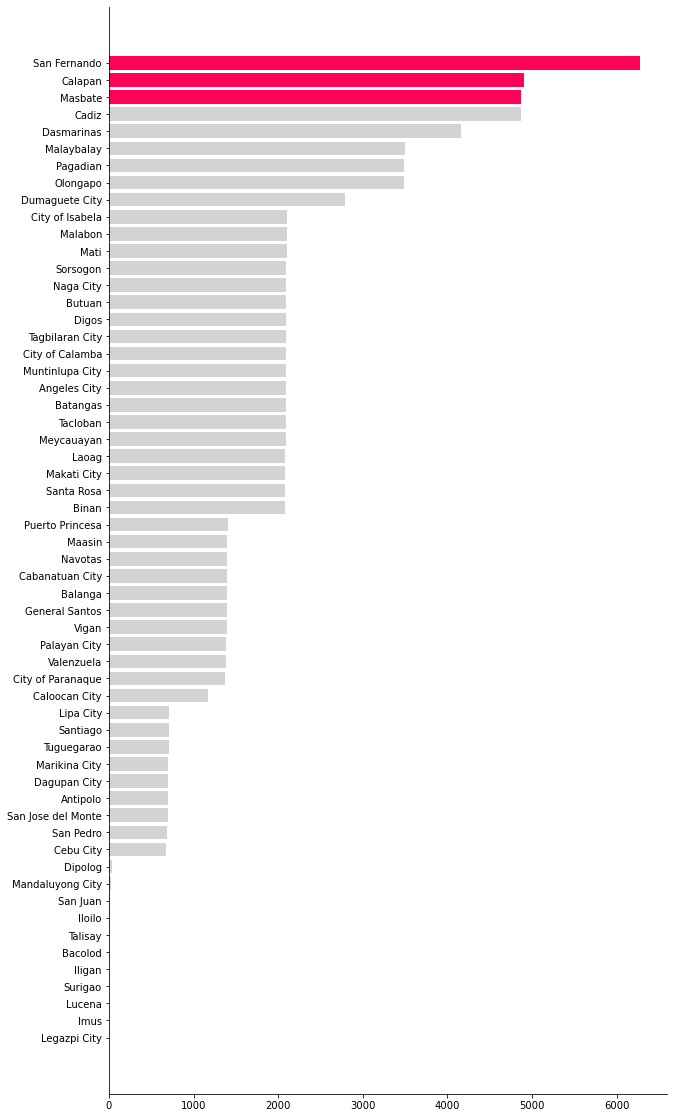

In [ ]:
cc_city_2 = pd.DataFrame({'trans_count': cc_fraud_eda['city'].value_counts().sort_values()})

colors_h = ['lightgray'] * len(cc_city.city.value_counts())
colors_h[-3:] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 20))
ax.barh(cc_city_2.index, cc_city_2.trans_count, color=colors_h)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
plt.show()

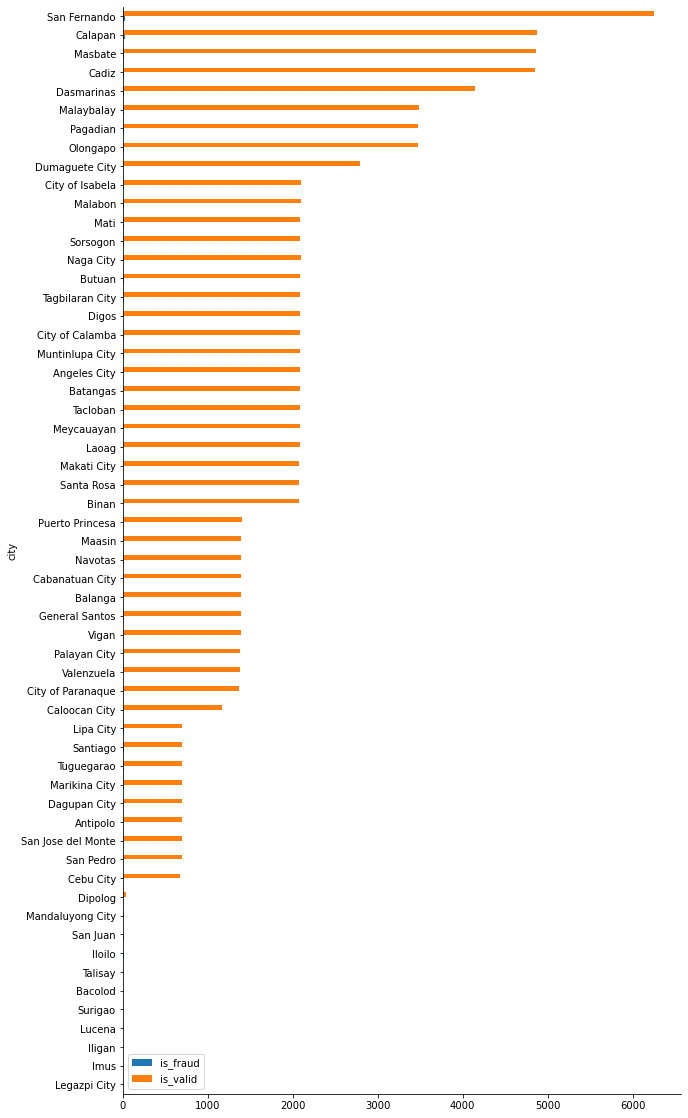

In [ ]:
cc_city_3 = pd.DataFrame(cc_fraud_eda.groupby('city')['is_fraud'].sum())
cc_city_3 = cc_city_3.join(cc_city_2).sort_values(['trans_count'])
cc_city_3['is_valid'] = cc_city_3['trans_count'] - cc_city_3['is_fraud']
cc_city_3 = cc_city_3[['is_fraud', 'is_valid']]

cc_city_3.plot.barh(figsize=(10,20))
ax = plt.gca()
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
plt.show()

### Jobs

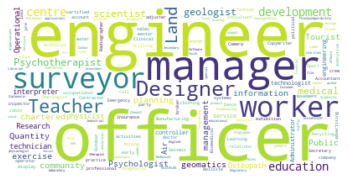

In [ ]:
cc_jobs = cc_fraud.loc[iso_in].drop_duplicates(subset=['full_name']).reset_index(drop=True)

words = []
for phrase in cc_jobs['job'].values:
    for word in phrase.split():
        words.append(word)
jobs_list = ' '.join(words)

stop_words = stopwords.words('english')
stop_words = set(stop_words)

wordcloud = WordCloud(background_color='white',
                      collocations=False, contour_width=2,
                     ).generate(jobs_list)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

### Merchant Category

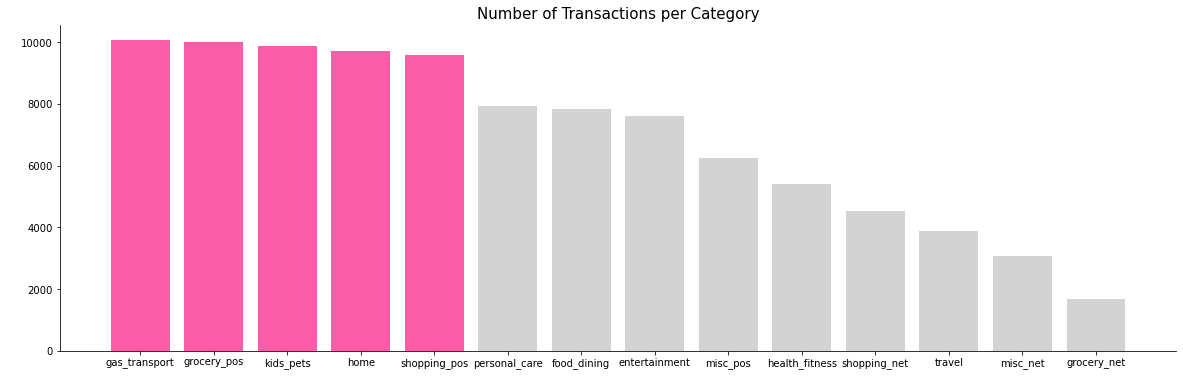

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))

colors_mc = ['lightgray'] * len((cc_fraud_eda.category.value_counts()))
colors_mc[:5] = ['#FD5DA8'] * 5

cc_mc = pd.DataFrame(cc_fraud_eda['category'].value_counts())

ax.bar(cc_mc.index, cc_mc.category, color=colors_mc)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
ax.set_title(f'Number of Transactions per Category', size=15, y=1)
plt.show()

### Date

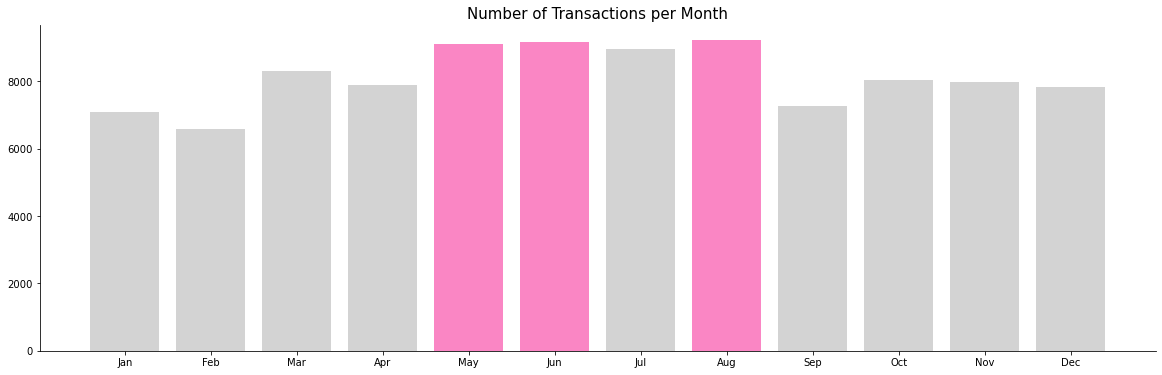

In [ ]:
date = pd.DataFrame(cc_fraud_eda['trans_month_'].value_counts()).reset_index().sort_values(['index'])
map_month = cc_fraud_eda.drop_duplicates(['trans_month'])[['trans_month', 'trans_month_']]
map_month.columns = ['trans_month', 'index']
cc_date = map_month.merge(date, on='index').sort_values(['trans_month'])

colors_d = ['lightgray'] * len((cc_fraud_eda.trans_month.value_counts()))
colors_d[4:6] = ['#FA86C4'] * 2
colors_d[7] = '#FA86C4'

fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(cc_date['index'], cc_date.trans_month_, color=colors_d)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
ax.set_title(f'Number of Transactions per Month', size=15, y=1)
plt.show()

### Correlation

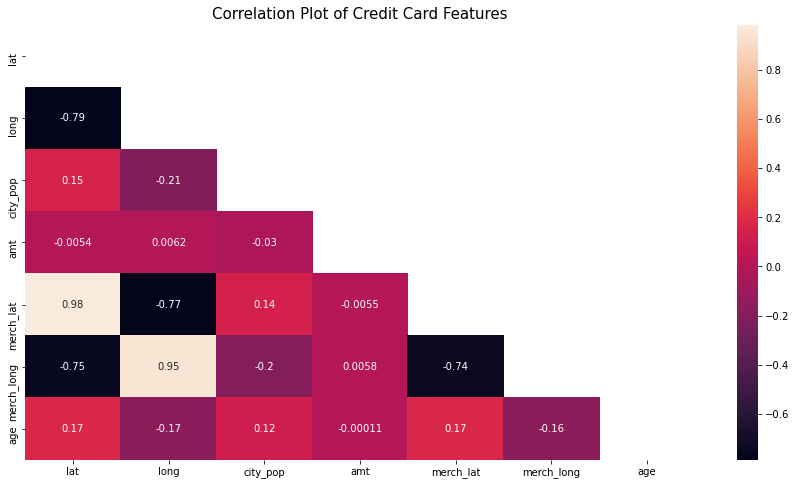

In [ ]:
quant = cc_fraud_eda[['lat', 'long', 'city_pop', 'amt', 'merch_lat', 'merch_long', 'age']]

corr = quant.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(corr, mask=mask, annot=True)
ax.set_title("Correlation Plot of Credit Card Features", fontsize=15, y=1)
plt.show()

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Baselining </span></div>

In [ ]:
df_target = cc_final['is_fraud']
state_counts = Counter(df_target)
df_state = pd.DataFrame.from_dict(state_counts, orient='index')

num=(df_state[0]/df_state[0].sum())**2
print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

Proportion Chance Criterion: 99.23%
1.25 * Proportion Chance Criterion: 124.04%


<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Exercise </span></div>

- Look for an imbalanced dataset (minority group at most 30%) that addresses at least one Sustainable Development Goals (SDG)
- Perform initial exploratory data analysis and outlier detection on the chosen dataset